In [1]:
# STEP 0: Imports
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import matplotlib.pyplot as plt


# STEP 1: Custom Dataset for Bubble Images
import random
from torchvision.transforms import functional as TF

import random
from torchvision.transforms import functional as TF
from torchvision import transforms

from torch.utils.data import Dataset
from torchvision.transforms import functional as TF
from torchvision import transforms
from PIL import Image
import random
import torch


class BubbleDataset(Dataset):
    def __init__(self, image_paths, label_paths, augment=False):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def center_crop(self, img, target_width=750, target_height=554):
        w, h = img.size
        left = (w - target_width) // 2
        top = (h - target_height) // 2
        right = left + target_width
        bottom = top + target_height
        return img.crop((left, top, right, bottom))

    def __getitem__(self, idx):
        # Load paths
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load images
        image = Image.open(image_path).convert('L')
        label = Image.open(label_path)

        # Keep original image before cropping/resizing
        original_image_tensor = TF.to_tensor(image).expand(3, -1, -1)  # [3, H, W]

        # Apply center crop (only width changes)
        image = self.center_crop(image, target_width=750)
        label = self.center_crop(label, target_width=750)

        # Resize to model input
        image = TF.resize(image, (256, 256))
        label = TF.resize(label, (256, 256), interpolation=Image.NEAREST)

        # Data Augmentation (if enabled)
        if self.augment:
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)
            if random.random() > 0.5:
                image = TF.vflip(image)
                label = TF.vflip(label)
            if random.random() > 0.5:
                angle = random.uniform(-5, 5)
                image = TF.rotate(image, angle)
                label = TF.rotate(label, angle, interpolation=Image.NEAREST)
            if random.random() > 0.5:
                image = TF.adjust_brightness(image, random.uniform(0.9, 1.1))
            if random.random() > 0.5:
                image = TF.adjust_contrast(image, random.uniform(0.9, 1.1))
            if random.random() > 0.5:
                i, j, h, w = transforms.RandomResizedCrop.get_params(
                    image, scale=(0.9, 1.0), ratio=(1.0, 1.0))
                image = TF.resized_crop(image, i, j, h, w, (256, 256))
                label = TF.resized_crop(label, i, j, h, w, (256, 256), interpolation=Image.NEAREST)
            if random.random() > 0.5:
                img_tensor = TF.to_tensor(image)
                noise = torch.randn_like(img_tensor) * 0.01
                img_tensor = (img_tensor + noise).clamp(0, 1)
                image = TF.to_pil_image(img_tensor)

        # Final conversion to tensor
        image = TF.to_tensor(image).expand(3, -1, -1)
        label = TF.pil_to_tensor(label).squeeze().long()
        label = (label > 127).long()

        return image, label, original_image_tensor, image_path, label_path

# STEP 2: Parsing and Splitting Data Based on Dataset Number
all_images = sorted(glob.glob('BubbleSegmentation/Data/US_2/*.jpg'))
all_labels = [img_path.replace('US', 'Label').replace('.jpg', '.png') for img_path in all_images]

# Extract dataset number (last digit before .jpg)
def extract_dataset_number(path):
    return int(path.split('_')[-1].split('.')[0])

groups = [extract_dataset_number(p) for p in all_images]

splitter = GroupShuffleSplit(n_splits=1, test_size=1/6)
print("Number of unique groups:", len(np.unique(groups)))
train_idx, val_idx = next(splitter.split(all_images, groups=groups))

# Optional: If you want to merge train & val into train (not common)
# train_idx = np.concatenate([train_idx, val_idx])

train_images = [all_images[i] for i in train_idx]
train_labels = [all_labels[i] for i in train_idx]
val_images = [all_images[i] for i in val_idx]
val_labels = [all_labels[i] for i in val_idx]

print(np.array(set([extract_dataset_number(p) for p in train_images])))
print(np.array(set([extract_dataset_number(p) for p in val_images])))

print("Sample mapping:")
for img, lbl in zip(train_images[:3], train_labels[:3]):
    print(f"{img}  -->  {lbl}")


# STEP 3: Transforms
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


train_dataset = BubbleDataset(train_images, train_labels, augment=True)
val_dataset = BubbleDataset(val_images, val_labels, augment=False)

train_datasets = sorted(set(extract_dataset_number(p) for p in train_images))
val_datasets = sorted(set(extract_dataset_number(p) for p in val_images))

print("Train dataset numbers:", train_datasets)
print("Validation dataset numbers:", val_datasets)


# STEP 4: Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# STEP 5: Check output of new dataset 
img_batch, lbl_batch, orig_img_batch, _, _ = next(iter(train_loader))

print("Image shape:", img_batch.shape)        # [B, 3, 256, 256]
print("Label shape:", lbl_batch.shape)        # [B, 256, 256]
print("Original Image shape:", orig_img_batch.shape)  # [B, 3, H, W]  <- original untouched

print("Label dtype:", lbl_batch.dtype)        # should be torch.int64
print("Label values:", lbl_batch.unique())    # should be tensor([0, 1])


Number of unique groups: 6
{1, 2, 3, 4, 5}
{6}
Sample mapping:
BubbleSegmentation/Data/US_2/t3US100_738966_1.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label100_738966_1.png
BubbleSegmentation/Data/US_2/t3US100_738966_2.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label100_738966_2.png
BubbleSegmentation/Data/US_2/t3US100_738966_3.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label100_738966_3.png
Train dataset numbers: [1, 2, 3, 4, 5]
Validation dataset numbers: [6]
Image shape: torch.Size([16, 3, 256, 256])
Label shape: torch.Size([16, 256, 256])
Original Image shape: torch.Size([16, 3, 256, 1024])
Label dtype: torch.int64
Label values: tensor([0, 1])


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT

try:
    from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
    weights = DeepLabV3_ResNet101_Weights.DEFAULT

    model = deeplabv3_resnet101(weights=weights)
    model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
    model = model.cuda()
    print("✅ Model successfully moved to CUDA")
except Exception as e:
    print("❌ CUDA error during model setup:", e)

✅ Model successfully moved to CUDA


In [3]:
# --- STEP 0: Imports ---
import os
import glob
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision import transforms


# --- STEP 1: Load Test Data ---
test_images = sorted(glob.glob('BubbleSegmentation/Data/US_Test_2023April7/*.jpg'))
test_labels = sorted(glob.glob('BubbleSegmentation/Data/Label_Test_2023April7/*.png'))

test_dataset = BubbleDataset(test_images, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


train_images = sorted(glob.glob('BubbleSegmentation/Data/US_2/*.jpg'))
train_labels = sorted(glob.glob('BubbleSegmentation/Data/Label_2/*.png'))

train_dataset = BubbleDataset(train_images, train_labels, augment=False)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
# --- STEP 2: Load Model ---
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
# import torch
# import torchvision.transforms.functional as TF
# import matplotlib.pyplot as plt
# from PIL import Image, ImageOps
# import random

# # --- Visualization Helpers ---
# def show_image(img, title="Image"):
#     w, h = img.size
#     plt.figure(figsize=(w / 100, h / 100))
#     cmap = "gray" if img.mode == "L" else None
#     plt.imshow(img, cmap=cmap)
#     plt.axis("off")
#     plt.title(title)
#     plt.show()

# def recover_original(img, final_width=1024, final_height=256, cropped_width=750, cropped_height=554):
#     # Step 1: Resize back to cropped size
#     img_resized = TF.resize(img, [cropped_height, cropped_width], interpolation=Image.NEAREST)

#     # Step 2: Pad to original size
#     pad_left = (final_width - cropped_width) // 2
#     pad_right = final_width - cropped_width - pad_left
#     pad_top = (final_height - cropped_height) // 2
#     pad_bottom = final_height - cropped_height - pad_top

#     img_padded = ImageOps.expand(img_resized, (pad_left, pad_top, pad_right, pad_bottom), fill=0)

#     return img_padded

# def visualize_final(img_path, pred_tensor, gt_tensor, idx, label_path):
#     orig_img = Image.open(img_path).convert("RGB")

#     # Convert pred and gt to PIL images
#     pred_pil = TF.to_pil_image(pred_tensor.byte() * 255)
#     gt_pil = TF.to_pil_image(gt_tensor.byte() * 255)

#     # Recover to original size
#     pred_recovered = recover_original(pred_pil)
#     gt_recovered = recover_original(gt_pil)

#     print(f"\nSample #{idx}")
#     print(f"Image Path: {img_path}")
#     print(f"Label Path: {label_path}")
#     show_image(orig_img, title="Original Image (1024x256)")
#     show_image(pred_recovered, title="Prediction Mask (Recovered to 1024x256)")
#     show_image(gt_recovered, title="Ground Truth Mask (Recovered to 1024x256)")

# # --- Inference + Visualization Loop ---
# all_samples = []

# with torch.no_grad():
#     for imgs, masks, orig_imgs, _, _ in test_loader:
#         imgs, masks = imgs.cuda(), masks.cuda()
#         preds = torch.argmax(model(imgs)['out'], dim=1)

#         for i in range(imgs.size(0)):
#             all_samples.append((
#                 imgs[i].cpu(),
#                 masks[i].cpu(),
#                 preds[i].cpu(),
#                 orig_imgs[i].cpu(),
#                 test_dataset.image_paths[len(all_samples)],
#                 test_dataset.label_paths[len(all_samples)]
#             ))

# print(f"Total samples = {len(all_samples)}")

# # Visualize Random 4 Samples
# for idx, (img, gt, pred, orig_img, img_path, label_path) in enumerate(random.sample(all_samples, 4)):
#     visualize_final(img_path, pred, gt, idx, label_path)


In [5]:
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random

# Redefining same function again for sake of simplicity
def recover_original(img, final_width=1024, final_height=256, cropped_width=750, cropped_height=554):
    # Step 1: Resize back to cropped size
    img_resized = TF.resize(img, [cropped_height, cropped_width], interpolation=Image.NEAREST)

    # Step 2: Pad to original size
    pad_left = (final_width - cropped_width) // 2
    pad_right = final_width - cropped_width - pad_left
    pad_top = (final_height - cropped_height) // 2
    pad_bottom = final_height - cropped_height - pad_top

    img_padded = ImageOps.expand(img_resized, (pad_left, pad_top, pad_right, pad_bottom), fill=0)

    return img_padded

def visualize_final(img_path, pred_tensor, gt_tensor, idx, label_path):
    orig_img = Image.open(img_path).convert("RGB")

    pred_pil = TF.to_pil_image(pred_tensor.byte() * 255)
    gt_pil = TF.to_pil_image(gt_tensor.byte() * 255)

    pred_recovered = recover_original(pred_pil)
    gt_recovered = recover_original(gt_pil)

    print(f"\nSample #{idx}")
    print(f"Image Path: {img_path}")
    print(f"Label Path: {label_path}")

    # --- Plot in a row of 3 ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    images = [orig_img, pred_recovered, gt_recovered]
    titles = ['Original Image', 'Prediction Mask', 'Ground Truth Mask']

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# --- Inference + Visualization Loop ---
all_samples = []

with torch.no_grad():
    for imgs, masks, orig_imgs, _, _ in test_loader:
        imgs, masks = imgs.cuda(), masks.cuda()
        preds = torch.argmax(model(imgs)['out'], dim=1)

        for i in range(imgs.size(0)):
            all_samples.append((
                imgs[i].cpu(),
                masks[i].cpu(),
                preds[i].cpu(),
                orig_imgs[i].cpu(),
                test_dataset.image_paths[len(all_samples)],
                test_dataset.label_paths[len(all_samples)]
            ))

print(f"Total samples = {len(all_samples)}")

# Visualize Random 10 Samples
# for idx, (img, gt, pred, orig_img, img_path, label_path) in enumerate(random.sample(all_samples, 10)):
#     visualize_final(img_path, pred, gt, idx, label_path)


Total samples = 400


In [6]:
import os
import re

# Extract pulse number from image filename
def extract_pulse(filename):
    base = os.path.basename(filename)
    pulse_match = re.search(r'US(\d+)', base)
    pulse = int(pulse_match.group(1)) if pulse_match else -1
    return pulse

# Step 1: Map pulses to their sample indices
pulse_idx_pairs = [
    (extract_pulse(img_path), idx)
    for idx, (_, _, _, _, img_path, _) in enumerate(all_samples)
]

# Step 2: Sort by pulse
pulse_idx_pairs_sorted = sorted(pulse_idx_pairs, key=lambda x: x[0])

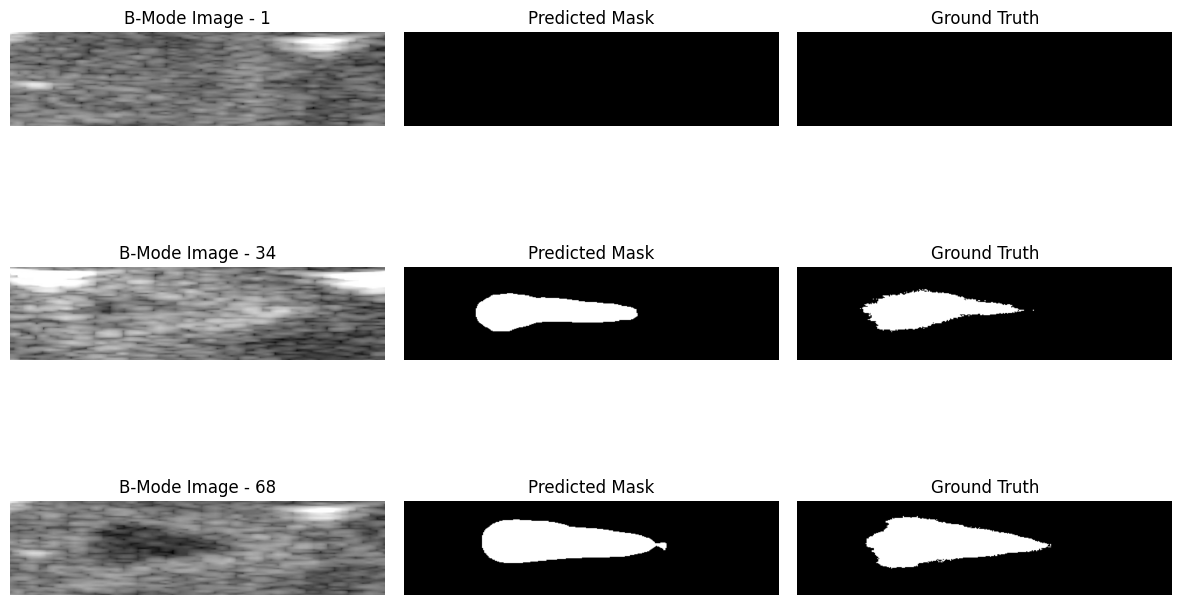

In [7]:

# Step 3: Pick every nth unique pulse
n = 134
selected_indices = [idx for i, (_, idx) in enumerate(pulse_idx_pairs_sorted) if i % n == 0]

# Step 4: Select corresponding samples
selected_samples = [all_samples[idx] for idx in selected_indices]

# Step 5: Plot
fig, axes = plt.subplots(len(selected_samples), 3, figsize=(15, 3 * len(selected_samples)))

for row_idx, (img, gt, pred, orig_img, img_path, label_path) in enumerate(selected_samples):
    orig_img = Image.open(img_path).convert("RGB")

    pred_pil = TF.to_pil_image(pred.byte() * 255)
    gt_pil = TF.to_pil_image(gt.byte() * 255)

    pred_recovered = recover_original(pred_pil)
    gt_recovered = recover_original(gt_pil)

    images = [orig_img, pred_recovered, gt_recovered]

    pulse = extract_pulse(img_path)
    titles = [f'B-Mode Image - {pulse}', 'Predicted Mask', 'Ground Truth']

    # print(f"\nSample #{row_idx}")
    # print(f"Pulse: {pulse}")
    # print(f"Image Path: {img_path}")
    # print(f"Label Path: {label_path}")

    for col, (ax, img, title) in enumerate(zip(axes[row_idx], images, titles)):
        ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
        ax.set_title(title)
        ax.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


In [8]:
pulse_list = [extract_pulse(img_path) for (_, _, _, _, img_path, _) in all_samples]

unique_pulses = sorted(list(set(pulse_list)))

print(f"Total Unique Pulses = {len(unique_pulses)}")
print("Unique Pulses =", unique_pulses)


Total Unique Pulses = 100
Unique Pulses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


Pulse to Index Mapping: {100: 0, 1: 44, 50: 180}

Sample #0
Pulse: 1
Image Path: BubbleSegmentation/Data/US_Test_2023April7/t3US1_738983_1.jpg

Sample #1
Pulse: 50
Image Path: BubbleSegmentation/Data/US_Test_2023April7/t3US50_738983_1.jpg

Sample #2
Pulse: 100
Image Path: BubbleSegmentation/Data/US_Test_2023April7/t3US100_738983_1.jpg


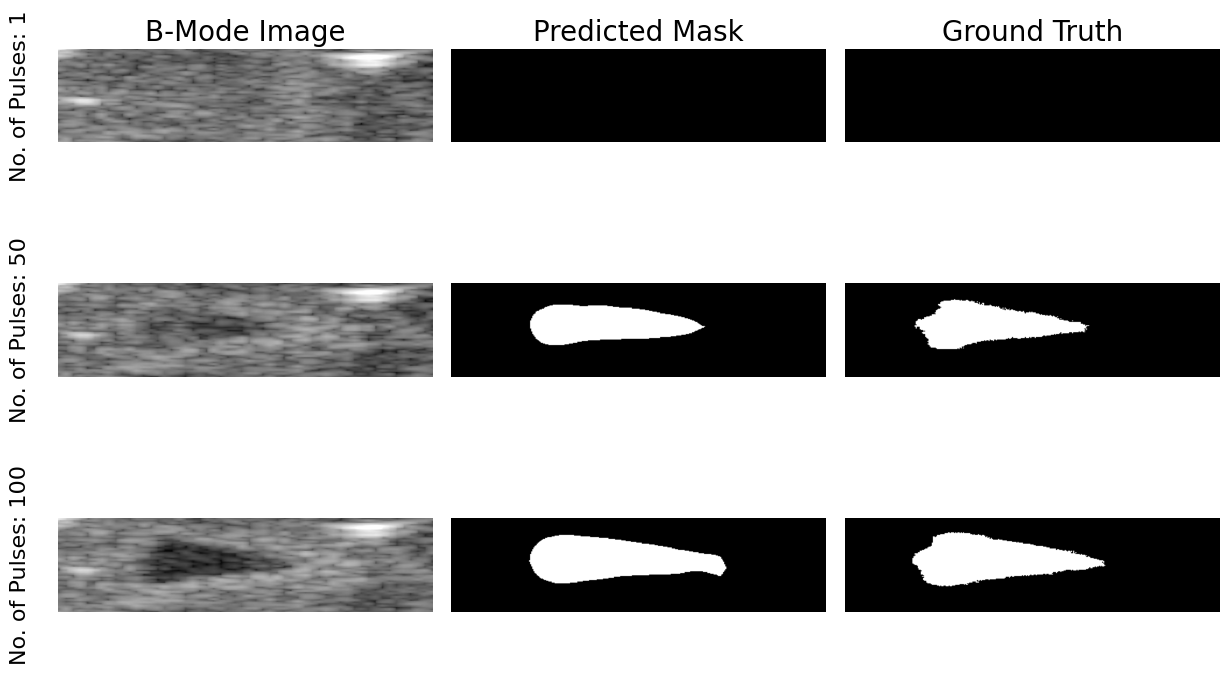

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF


# --- Main Code ---
# Desired pulses to plot
desired_pulses = [1, 50, 100]

# Build a map from pulse value to sample index (first occurrence only)
pulse_idx_map = {}
for idx, (_, _, _, _, img_path, _) in enumerate(all_samples):
    pulse = extract_pulse(img_path)
    if pulse in desired_pulses and pulse not in pulse_idx_map:
        pulse_idx_map[pulse] = idx  # Pick first occurrence

print("Pulse to Index Mapping:", pulse_idx_map)

# Prepare selected samples based on the desired pulses
selected_samples = [all_samples[pulse_idx_map[pulse]] for pulse in desired_pulses if pulse in pulse_idx_map]

# Create a subplot grid with as many rows as selected samples and 3 columns.
fig, axes = plt.subplots(len(selected_samples), 3, figsize=(15, 3 * len(selected_samples)))

# If only one row exists, ensure axes is 2D for consistency.
if len(selected_samples) == 1:
    axes = [axes]

# Set the column titles (only once, on the top row)
column_titles = ['B-Mode Image', 'Predicted Mask', 'Ground Truth']
for col_idx, title in enumerate(column_titles):
    axes[0][col_idx].set_title(title, fontsize=20)

# Now plot each sample without additional row titles;
# Instead, annotate each B-Mode image with "No. of Pulses: X"
for row_idx, (img, gt, pred, orig_img, img_path, label_path) in enumerate(selected_samples):
    # Load and prepare images
    orig_img = Image.open(img_path).convert("RGB")
    pred_pil = TF.to_pil_image(pred.byte() * 255)
    gt_pil = TF.to_pil_image(gt.byte() * 255)
    
    pred_recovered = recover_original(pred_pil)
    gt_recovered = recover_original(gt_pil)
    
    images = [orig_img, pred_recovered, gt_recovered]
    pulse = extract_pulse(img_path)
    
    print(f"\nSample #{row_idx}")
    print(f"Pulse: {pulse}")
    print(f"Image Path: {img_path}")
    
    for col_idx, (ax, im) in enumerate(zip(axes[row_idx], images)):
        ax.imshow(im, cmap='gray' if im.mode == 'L' else None)
        ax.axis('off')
        # For the B-Mode image (first column), add the pulse count as an annotation.
        if col_idx == 0:
            ax.text(-0.1, 0.5, f'No. of Pulses: {pulse}',
                    transform=ax.transAxes, fontsize=16, ha='center', va='center',
                    rotation=90)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
